In [48]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_04.ipynb")

In [49]:
rng_seed = 42

## Homework 4

## <em> Mixture Models and Expectation Maximization</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

### Imports

In [50]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

import math
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import optimize

#### Problem 1 - Mixture Model for Outliers

Suppose we have data that can be fit to a linear regression, apart from a few outlier points. It is always better to understand the underlying generative model of outliers. <br><br>
Consider the following dataset, relating the observed variables $x$ and $y$, and the error of $y$ stored in $\sigma_y$. <br><br>
We'll propose a simple linear model, which has a slope and an intercept encoded in a parameter vector $\theta$. The model is defined as follows:

$$\hat{y} (x|\theta) = \theta_0 + \theta_1 x$$
Given this model, we can compute a Gaussian likelihood for each point:
$$p(x_i, y_i, e_i|\theta) \propto \exp \left[ - \frac{1}{2e_i^2} (y_i - \hat{y} (x_i |\theta))^2\right]$$
The total likelihood is the product of all the individual likelihoods. Computing this and taking the log, we have:
$$\log L(D |\theta) = \mathrm{const} - \sum_i \frac{1}{2e_i^2} (y_i - \hat{y} (x_i |\theta))^2 $$
This should all look pretty familiar if you read through the previous post. This final expression is the log-likelihood of the data given the model, which can be maximized to find the $\theta$ corresponding to the maximum-likelihood model. Equivalently, we can minimize the summation term, which is known as the loss:
$$\mathrm{loss} = \sum_i \frac{1}{2e_i^2} (y_i - \hat{y} (x_i |\theta))^2$$
This loss expression is known as a squared (or L2) loss; here we've simply shown that the squared loss can be derived from the Gaussian log likelihood.

In [51]:
# Load the data
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

<span style="color:blue"> <i> 1. Determine $\theta = [\theta_0, \theta_1]$ which maximize the likelihood (or, equivalently, minimize the loss). You can use scipy.optimize.fmin. Plot the best-fit line (on top of data points) using $\theta$ from the MLE solution. </i></span><br>

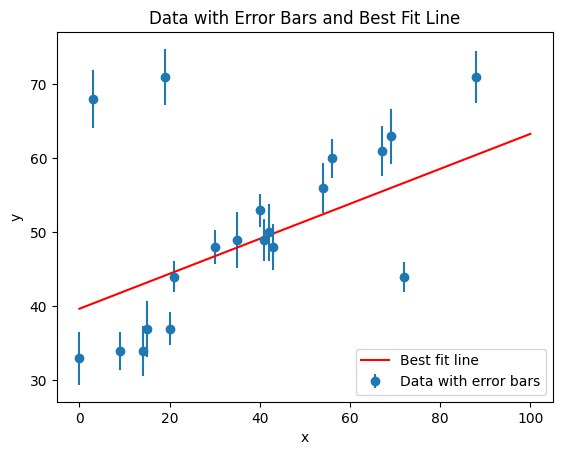

In [52]:

def squared_loss(theta, x=x, y=y, e=e):
    # Unpack theta
    theta0, theta1 = theta

    # Compute the predicted values
    y_pred = theta0 + theta1 * x

    # Compute the squared loss
    loss = np.sum(((y - y_pred) / e) ** 2)

    return loss

theta1 = optimize.minimize(squared_loss, x0=[0, 0]).x



xfit = np.linspace(0, 100)
# make your plot here:
plt.errorbar(x, y, yerr=e, fmt='o', label='Data with error bars')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, label='Best fit line', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data with Error Bars and Best Fit Line')
plt.legend()
plt.show()

In [53]:
grader.check("q1.1")

q1.1 results: All test cases passed!

Clearly, we get a poor fit to the data because the squared loss is overly sensitive to outliers.

The Bayesian approach to accounting for outliers generally involves modifying the model so that the outliers are accounted for. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers. One option is to choose a mixture between a signal and a background:
$$p(\{x_i\}, \{y_i\}, \{e_i\} |\theta, \{g_i\}, \sigma, \sigma_B) = \frac{g_i}{\sqrt{2\pi e_i^2}} \exp\left[-\frac{(\hat{y}(x_i|\theta)-y_i)^2}{2e_i^2}\right] + \frac{1-g_i}{\sqrt{2\pi \sigma_B^2}} \exp\left[-\frac{(\hat{y}(x_i|\theta)-y_i)^2}{2\sigma_B^2}\right]$$
What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

Our model is much more complicated now: it has 22 parameters rather than 2, but the majority of these can be considered nuisance parameters, which can be marginalized-out in the end. Let's construct a function which implements this likelihood. As we have not yet covered MCMC sampling in the class, we will implement a negative log likelihood and make use of scipy.optimize.minimize to find the optimal likelihood parameters, taking advantage of the L-BFGS-B bounded optimization algorithm to optimize under our uniform priors.

We have clear bounded priors for our parameters: $g_i \in [0, 1]$ and $\sigma_B > 0$, while the parameters $\theta_0$ and $\theta_1$ are unbounded.

<span style="color:blue"> <i> 2. Define the log-likelihood and negative log likelihood functions, for optimization. </i></span><br>

In [54]:
from scipy.optimize import minimize

In [55]:
from scipy.stats import norm

def log_likelihood(theta, x=x, y=y, e=e):
    # theta[0] is the y intercept, theta[1] is the slope
    sigma_B = theta[2]
    g = np.clip(theta[3:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm

    lnL = np.sum( np.log( (1-g) * norm.pdf(y, theta[0] + theta[1]*x, sigma_B) + g * norm.pdf(y, theta[0] + theta[1]*x, e) ) )

    return lnL

def minus_log_likelihood(theta):
    return -log_likelihood(theta)

Now, follow the documentation for defining bounds in scipy.optimize.minimize and define the bounds for the input. You can define bounds as a list of tuples. Note that 'no bound' is defined by using ``None`` instead of a bound value.

In [56]:
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)] + [(0, 1)] * len(x)

initialize a number of random starting points within the bounds (note that if you initialize only one starting point, you may not find the best-fit values), then do the optimization for each to get the optimal best fit. 
                                                                                                                                                                                      
Your optimal value for x is the                                                                                                                                                                                       

In [57]:
np.random.seed(rng_seed)

# Define the optimization function
opt_fn = minus_log_likelihood

# This is the output for your function, minimize this for different initial conditions.
opt_fn = minus_log_likelihood
for i in range(10):
    # Start with different initializations of x0 (np.random.uniform with different ranges is recommended)
    x0 = [np.random.uniform(0, 1), np.random.uniform(-2, 0)] + [np.random.uniform(0.1, 10)] + list(np.random.uniform(0, 1, size=len(x)))

    # Now do the optimization using the L-BFGS-B method with your defined bounds
    opt_p = optimize.minimize(opt_fn, x0, bounds=bounds, method='L-BFGS-B')

    # Select opt_p if it is the most minimal likelihood. You can use opt_p.fun to get the function results.
    opt_p_best = opt_p if i == 0 else opt_p_best if opt_p.fun < opt_p_best.fun else opt_p_best

# Your optimal values:
opt_values = opt_p_best.x

In [58]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

We allowed the model to have a nuisance parameter $0 < g_i < 1$ for each data point: $g_i = 0$ indicates an outlier. We can also allow $\sigma_B$ to be a nuisance parameter to marginalize over (or just make it a large number). Now, let us define an outlier whenever posterior $E(g_i) < 0.5$.
<br><br>
<span style="color:blue"> <i> 3. Using such cutoff at $g = 0.5$, identify an outlier and mark them on the plot. Also, plot the new and old best-fit models over the original data. </i></span><br>

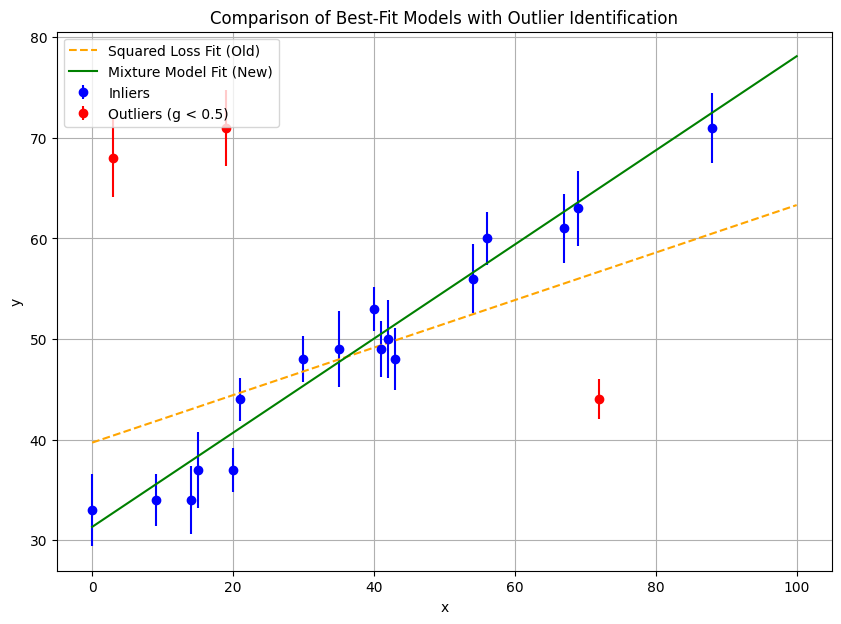

In [59]:
# Extract parameters
theta2 = opt_values[:2]
g = opt_values[3:]

# Identify outliers where g < 0.5
outliers_mask = g < 0.5
inliers_mask = ~outliers_mask

# Plot the results
plt.figure(figsize=(10, 7))

# Plot the inlier points
plt.errorbar(x[inliers_mask], y[inliers_mask], yerr=e[inliers_mask], fmt='o', color='blue', label='Inliers')

# Plot and highlight the outlier points
plt.errorbar(x[outliers_mask], y[outliers_mask], yerr=e[outliers_mask], fmt='o', color='red', label='Outliers (g < 0.5)')

# Plot the old best-fit line (from squared loss)
xfit = np.linspace(0, 100, 1000)
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='orange', linestyle='--', label='Squared Loss Fit (Old)')

# Plot the new best-fit line (from mixture model)
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='green', linestyle='-', label='Mixture Model Fit (New)')

plt.title('Comparison of Best-Fit Models with Outlier Identification')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

<!-- END QUESTION -->

#### Problem 2 - Supernova

In this homework, we use a compilation of supernovae data to show that the expansion of the universe is accelerating, and hence it contains dark energy. This is the Nobel prize winning research in 2011 (https://www.nobelprize.org/nobel_prizes/physics/laureates/2011/), and Saul Perlmutter, a professor of physics at Berkeley, shared a prize in 2011 for this discovery.
<br><br>
"The expansion history of the universe can be determined quite easily, using as a “standard candle” any distinguishable class of astronomical objects of known intrinsic brightness that can be identified over a wide distance range. As the light from such beacons travels to Earth through an expanding universe, the cosmic expansion stretches not only the distances between galaxy clusters, but also the very wavelengths of the photons en route. By the time the light reaches us, the spectral wavelength $\lambda$ has thus been redshifted by precisely the same incremental factor $z = \Delta \lambda/\lambda$ by which the cosmos has been stretched in the time interval since the light left its source. The recorded redshift and brightness of each such object thus provide a measurement of the total integrated expansion of the universe since the time the light was emitted. A collection of such measurements, over a sufficient range of distances, would yield an entire historical record of the universe’s expansion." (Saul Perlmutter, http://supernova.lbl.gov/PhysicsTodayArticle.pdf).
<br><br>
Supernovae emerge as extremely promising candidates for measuring the cosmic expansion. Type I Supernovae arises from the collapse of white dwarf stars when the Chandrasekhar limit is reached. Such nuclear chain reaction occurs in the same way and at the same mass, the brightness of these supernovae are always the same. The relationship between the apparent brightness and distance of supernovae depend on the contents and curvature of the universe.
<br><br>
We can infer the "luminosity distance" $D_L$ from measuring the inferred brightness of a supernova of luminosity $L$. Assuming a naive Euclidean approach, if the supernova is observed to have flux $F$, then the area over which the flux is distributed is a sphere radius $D_L$, and hence <br><br>
$$F = \frac{L}{4\pi D_L^2}.$$
<br>
In Big Bang cosmology, $D_L$ is given by:
<br><br>
$$ D_L = \frac{\chi(a)}{a} $$
<br>
where $a$ is the scale factor ($\frac{\lambda_0}{\lambda} = 1 + z = \frac{a_0}{a}$, and the quantity with the subscript 0 means the value at present. Note that $a_0 = 1, z_0 = 0$.), and $\chi$ is the comoving distance, the distance between two objects as would be measured instantaneously today. For a photon, $cdt = a(t)d\chi$, so $\chi(t) = c\int_t^{t_0} \frac{dt'}{a(t')}$. We can write this in terms of a Hubble factor ($H(t) = \frac{1}{a}\frac{da}{dt}$), which tells you the expansion rate: $\chi(a) = c\int_a^1 \frac{da'}{a'^2H(a')} = c\int_0^z \frac{dz'}{H(z')}$. (change of variable using $a = \frac{1}{1+z}$.)
<br><br>
Using the Friedmann equation (which basically solves Einstein's equations for a homogenous and isotropic universe), we can write $H^2$ in terms of the mass density $\rho$ of the components in the universe: $H^2(z) = H_0^2[\Omega_m(1+z)^3 + (1-\Omega_m)(1+z)^2].$ <br><br>
$\Omega$ is the density parameter; it is the ratio of the observed density of matter and energy in the universe ($\rho$) to the critical density $\rho_c$ at which the universe would halt is expansion. So $\Omega_0$ (again, the subscript 0 means the value at the present) is the total mass and energy density of the universe today, and consequently $\Omega_0 = \Omega_{m}$ (matter density parameter today; remember we obtained the best-fit value of this parameter in Project 1?) = $\Omega_{\mathrm{baryonoic\ matter}}$ + $\Omega_{\mathrm{dark\ matter}}$. If $\Omega_0 < 1$, the universe will continue to expand forever. If $\Omega_0 > 1$, the expansion will stop eventually and the universe will start to recollapse. If $\Omega_0 = 1$, then the universe is flat and contains enough matter to halt the expansion but not enough to recollapse it. So it will continue expanding, but gradually slowing down all the time, finally running out of steam only in the infinite future. Even including dark matter in this calculation, cosmologists found that all the matters in the universe only amounts to about a quarter of the required critical mass, suggesting a continuously expanding universe with deceleration. Then, using all this, we can write the luminosity distance in terms of the density parameters: <br><br>
$$ D_L = \frac{\chi(a)}{a} = c(1+z)\int_0^z \frac{dz'}{H(z')} = c(1+z)\int_0^z \frac{dz'}{H_0[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^2]^{1/2}}  $$ <br>
$$ = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^2]^{1/2}}\ [unit\ of\ Mpc] $$
<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$.
<br><br>
Fluxes can be expressed in magnitudes $m$, where $m = -2.5\cdot\mathrm{log}_{10}F$ + const. The distance modulus is $\mu = m - M$ ($M$ is the absolute magnitude, the value of $m$ if the supernova is at a distance 10pc. Then, we have:
<br><br>
$$ \mu = 25 + 5\cdot \mathrm{log}_{10}\Big(D_L\ [in\ the\ unit\ of \ Mpc]\Big)$$
<br><br>
In this assignment, we use the SCP Union2.1 Supernova (SN) Ia compilation. (http://supernova.lbl.gov/union/)
<br><br>
First, load the measured data: $z$ (redshift), $\mu$ (distance modulus), $\sigma(\mu)$ (error on distance modulus)


In [60]:
data = np.loadtxt("./sn_z_mu_dmu_plow_union2.1.txt", usecols=range(1,5))
# z
z_data = data[:,0]
# mu
mu_data = data[:,1]
# error on mu (sigma(mu))
mu_err_data = data[:,2]

***

Let us assume that the universe is flat (which is a fair assumption since the CMB measurements indicate that the universe has no large-scale curvature). $\Omega_0 = \Omega_m + \Omega_{DE} = 1$. Then, we do not need to worry about the curvature term:<br><br>
$$ D_L = \frac{\chi(a)}{a} = c(1+z)\int_0^z \frac{dz'}{H(z')} = c(1+z)\int_0^z \frac{dz'}{H_0[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}}  $$ <br>
$$ = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}}\ [unit\ of\ Mpc] $$<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$.<br><br>
Assuming that errors are Gaussian (can be justified by averaging over large numbers of SN; central limit theorem), we calculate the likelihood $L$ as: <br><br>
$$ L \propto \mathrm{exp}\Big( -\frac{1}{2} \sum_{i = 1}^{N_{\mathrm{SN}}} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m, w)]^2}{\sigma(\mu_i)^2} \Big) $$
<br>
where $z_i, \mu_i, \sigma(\mu_i)$ are from the measurements, and we compute $\mu_{model}$ as a function of $z, \Omega_m, w$.

<br><br>
First, try the <b> Maximum A Posteriori (MAP) method</b>.
<br><br>

<span style="color:blue"> <i> 1. Assuming that $h$ = 0.7, find the MAP estimation of $\Omega_m$ and $w$ (i.e. find $\Omega_m$ and $w$ which maximizes the likelihood.). As our priors are simple bounds on the parameters ($\Omega_m \geq 0$ and $w \leq 0$), we can use the L-BFGS-B method of bounded optimziation as the previous question)
</i></span><br><br>
(Hint: This is very similar to the previous problem. Take the log of the likelihood and maximize it using scipy.optimize.minimize (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) using the L-BFGS-B bounded optimization method as above. The Bounds have been given to you. Note that you need to make initial guesses on the parameters in order to use optimize.minimize . You can set them to be 0. Caveat: "optimize.minimize" minimizes a given function, so you should multiply the log-likelihood by $-1$ in order to maximize it using this function.)
<br>


In [61]:
# Compute the terms in the mu model:
theta1 = np.vectorize(lambda z, Omegam, w: quad(lambda zp: 1 / np.sqrt(Omegam*(1+zp)**3 + (1-Omegam)*(1+zp)**(3*(1+w))), 0, z)[0])

In [62]:
def minus_log_likelihood(param):
    "Ln of likelihood for flat Universe and SN distance modulus data"
    Omegam, w = param
    h = 0.7
    data = np.loadtxt("./sn_z_mu_dmu_plow_union2.1.txt", usecols=range(1,5))
    z_data = data[:,0]
    mu_data = data[:,1]
    mu_err_data = data[:,2]
    mu_model = 25 + 5 * np.log10( (2997.92458 / h) * (1 + z_data) * theta1(z_data, Omegam, w) )
    lnL = -0.5 * np.sum( (mu_data - mu_model)**2 / mu_err_data**2 )

    return -lnL

bounds = [(0, None), # Bound for Omegam: lower bound of 0 and no upper bound
          (None, 0)] # Bound for w: no lower bound, upper bound of 0

In [63]:
# opt_p is the result of your optimize.minimize function
opt_p = optimize.minimize(minus_log_likelihood, x0=[0.3, -1], bounds=bounds, method='L-BFGS-B')
Omegam, w = opt_p.x

print('MAP solution')
print('Omega_m = ', Omegam, ', w = ', w)

MAP solution
Omega_m =  0.2796370697421812 , w =  -1.0044870383155542


In [64]:
grader.check("q2.1")

q2.1 results: All test cases passed!

***

<br><br>
Now, include the distance modulus of 12 additional supernovae, which are not-so-good standard candles. They are 3$\sigma$ away from the best-fit mode.

In [65]:
# with outliers included
data = np.loadtxt("./sn_z_mu_dmu_plow_union2.1_outlier.txt", usecols=range(1,5))
# z
z_data = data[:,0]
# mu|
mu_data = data[:,1]
# error on mu (sigma(mu))
mu_err_data = data[:,2]

<!-- BEGIN QUESTION -->

So we have a total of 592 supernovae, and we can see that the last 12 supernovae seem to be outliers. (i.e. mu_data[580:] contains the distance modulus measurements of these 12 supernovae.)
<br><br>
<span style="color:blue"> <i> 2. Plot the measurements of all 592 supernovae (with errorbar). Show the last 12 supernovae (outliers) with a different color. </i></span><br>

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_1997/3363512136.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


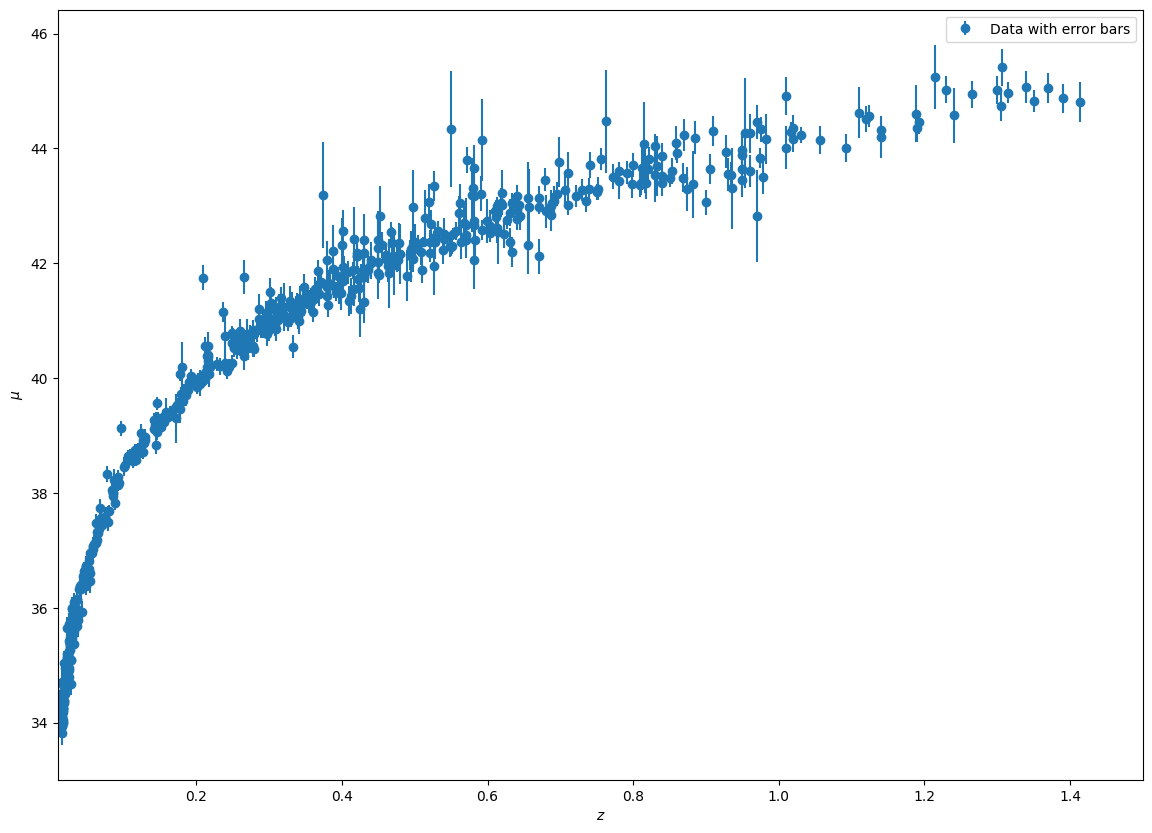

In [66]:
plt.figure(figsize = (14,10))

plt.errorbar(z_data, mu_data, yerr=mu_err_data, fmt='o', label='Data with error bars')

plt.legend()
plt.xlim(0.01, 1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.show()

<!-- END QUESTION -->

<span style="color:blue"> 3. With 12 outliers included, run the same optimization method as previous to get the new MLE with bounds values on $\Omega_m$ and $w$. Print your constraints on $w$ and $\Omega_m$.
</span>

In [67]:
# The data with outliers was loaded in cell [18].
# We need to redefine the likelihood function to use this new data.

def minus_log_likelihood_outlier(param):
    """Calculates negative log-likelihood for the outlier dataset."""
    Omegam, w = param
    h = 0.7
    
    # Use the outlier data that is already loaded in the notebook's global variables
    mu_model = 25 + 5 * np.log10( (2997.92458 / h) * (1 + z_data) * theta1(z_data, Omegam, w) )
    lnL = -0.5 * np.sum( (mu_data - mu_model)**2 / mu_err_data**2 )

    return -lnL

# Define the bounds for the parameters
bounds = [(0, None),  # Omegam >= 0
          (None, 0)]  # w <= 0

# Re-run the optimization using the new function and initial guesses
opt_p_outlier = optimize.minimize(minus_log_likelihood_outlier, x0=[0.3, -1], bounds=bounds, method='L-BFGS-B')

# Assign the results to the variables the grader will check
Omegam_q3, w_q3 = opt_p_outlier.x

print('(Outliers Included) MAP solution')
print(f'Omega_m = {Omegam_q3}, w = {w_q3}')

(Outliers Included) MAP solution
Omega_m = 0.34204112660448344, w = -1.188966979377508


In [68]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<br><br>
Remember that in Problem 1, we used the Gaussian mixture to better model the measurements with outliers. Let us apply the same technique in this case.
<br><br>
$$ L = \prod_{i = 1}^{N_{\mathrm{SN}}} \Big[ \frac{g}{\sqrt{2\pi\sigma(\mu_i)^2}}\mathrm{exp}\Big( -\frac{1}{2} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m, w)]^2}{\sigma(\mu_i)^2} \Big) + \frac{1-g}{\sqrt{2\pi\sigma_B^2}}\mathrm{exp}\Big( -\frac{1}{2} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m, w) + \Delta \mu]^2}{\sigma_B^2} \Big) \Big] $$
<br>
Here, we have 5 free parameters: $\Omega_m, w, \sigma_B, g, \Delta \mu$.
<br><br>
With outliers, we think there is something in the noise we do not really understand, which makes error distribution non-Gaussian. So we hope adding a second Gaussian to the model would better describe the pdf. $g$ determines weights on the two Gaussians. $\sigma_B^2$ is the variance of the second Gaussian, which we assume to be larger than the variance of the first Gaussian. $\Delta \mu$ is the distance modulus offset in the second Gaussian.
<br><br>

Note the difference between here and our method in Problem 1: Here we only have one $g$ parameter instead of a $g_i$ for each data point. This is because we are not looking for detecting outliers individually in this problem. Rather, we only want to marginalize out the outliers so we only want a generalized distribution for the mixture model rather than assigning each data point to be "data" or "noise".

Use the bounds $\Omega_m \geq 0$, $w \leq 0$, $\sigma_B \geq 0$, $0 \leq g \leq 1$, and the same L-BFGS-B method as before to find the parameters $\Omega_0$ and $w$ in the presence of outliers. Note that you may have to experiment with starting point x0.

<span style="color:blue"> <i> 4. Use scipy.optimize.minimize to minimize this new model likelihood function.. Print your MAP optimal values on $w$ and $\Omega_m$, as well as your optimal value on $g$. Note that you may have to experiment with different starting points.  </i></span><br>

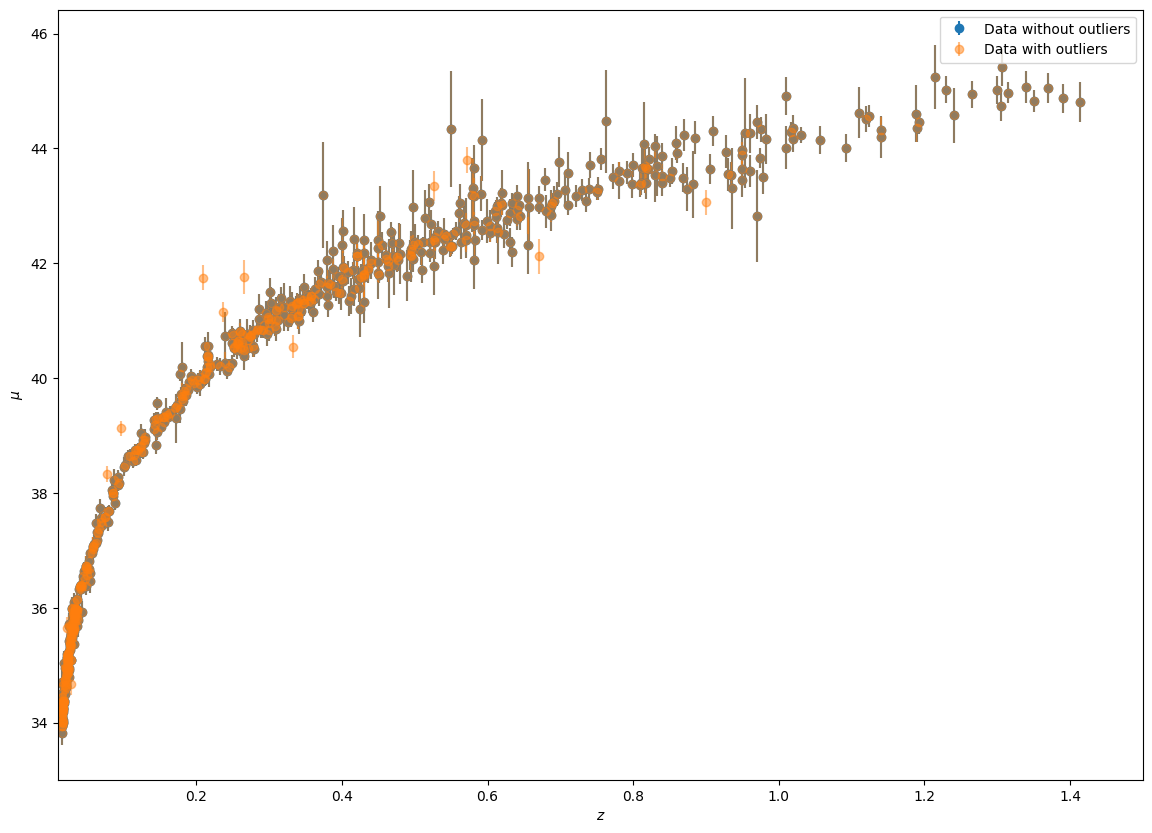

In [76]:
# without outliers
data = np.loadtxt("./sn_z_mu_dmu_plow_union2.1.txt",usecols=range(1,5))
# z
z_data = data[:,0]
# mu
mu_data = data[:,1]
# error on mu (sigma(mu))
mu_err_data = data[:,2]
# with outliers included
data_outlier = np.loadtxt("./sn_z_mu_dmu_plow_union2.1_outlier.txt",usecols=range(1,5))
# z
z_data_outlier = data_outlier[:,0]
# mu
mu_data_outlier = data_outlier[:,1]
# error on mu (sigma(mu))
mu_err_data_outlier = data_outlier[:,2]
plt.figure(figsize = (14,10))
plt.errorbar(z_data, mu_data, yerr=mu_err_data, fmt='o', label='Data without outliers')
plt.errorbar(z_data_outlier, mu_data_outlier, yerr=mu_err_data_outlier, fmt='o', label='Data with outliers', alpha=0.5)
plt.legend()
plt.xlim(0.01, 1.5)
plt.xlabel(r'$z$')      # Use raw string
plt.ylabel(r'$\mu$')     # Use raw string
plt.show()

In [ ]:
from scipy.stats import norm

def minus_log_likelihood_mixture(param):
    """Calculates negative log-likelihood for the 5-parameter mixture model."""
    Omegam, w, sigma_B, g, mu_offset = param
    h = 0.7

    # Use the data with outliers
    mu_model = 25 + 5 * np.log10((2997.92458 / h) * (1 + z_data_outlier) * theta1(z_data_outlier, Omegam, w))
    delta_mu = mu_data_outlier - mu_model

    # Likelihood of the first Gaussian (main data)
    like1 = g * norm.pdf(delta_mu, 0, mu_err_data_outlier)
    
    # Likelihood of the second Gaussian (outliers)
    # The formula in the prompt uses sigma_B as the standard deviation directly.
    # A small epsilon is added to prevent errors if sigma_B approaches zero.
    like2 = (1 - g) * norm.pdf(delta_mu, mu_offset, sigma_B + 1e-10)

    # Total likelihood. Add a small epsilon to prevent log(0).
    total_like = np.sum(np.log(like1 + like2 + 1e-10)) 

    return -total_like

# Bounds for the 5 parameters: [Omegam, w, sigma_B, g, mu_offset]
bounds_mixture = [(0, None),      # Omegam >= 0
                  (None, 0),      # w <= 0
                  (1e-5, None),   # sigma_B > 0
                  (0, 1),         # 0 <= g <= 1
                  (None, None)]   # mu_offset is unbounded

# Initial guess for the parameters
x0_mixture = [0.3, -1.0, 1.0, 0.95, 0.0]

# Run the optimization
opt_p_mixture = optimize.minimize(minus_log_likelihood_mixture, x0=x0_mixture, bounds=bounds_mixture, method='L-BFGS-B')

# Assign results to the variables for the grader
Omegam_q4, w_q4, _, g_q4, _ = opt_p_mixture.x

print('(Outliers Included) MAP solution - Gaussian Mixture Model')
print(f'Omega_m = {Omegam_q4}')
print(f'w = {w_q4}')
print(f'g = {g_q4}')

(Outliers Included) MAP solution - Gaussian Mixture Model
Omega_m = 0.27825718879827915
w = -0.9800546330188539
g = 0.9479295958634831


In [80]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 5. Using the estimates of $\Omega_m$ and $w$ from your MAP results in Part 3 and Part 4, calculate the distance modulus from theory and plot the curves on top of the measured data. See how they fit. Make sure to highlight the outliers as before. </i></span><br>

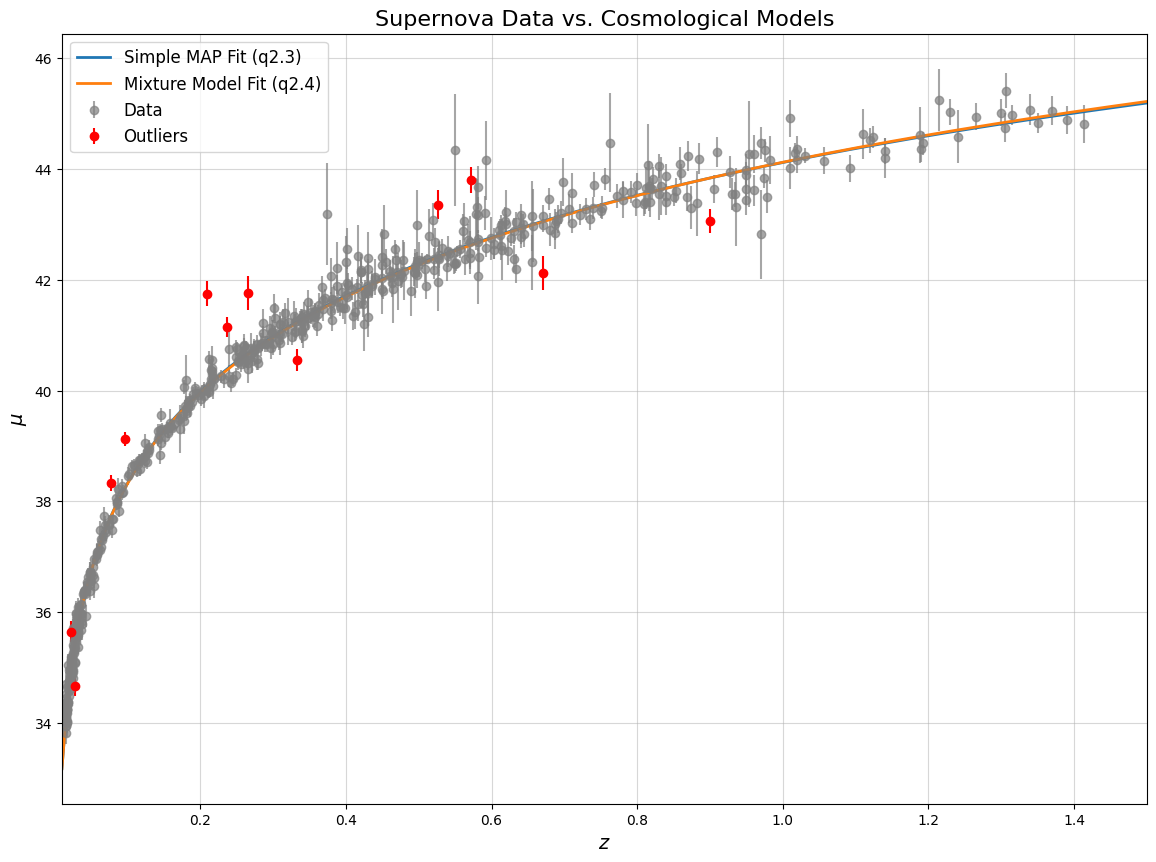

In [ ]:
# Create a smooth range of z values for plotting the theoretical curves
z_fit = np.linspace(0.01, 1.5, 200)
h = 0.7

# --- Calculate theoretical mu for the two models ---

dl_q3 = (2997.92458 / h) * (1 + z_fit) * theta1(z_fit, Omegam_q3, w_q3)
mu_fit_q3 = 25 + 5 * np.log10(dl_q3)

dl_q4 = (2997.92458 / h) * (1 + z_fit) * theta1(z_fit, Omegam_q4, w_q4)
mu_fit_q4 = 25 + 5 * np.log10(dl_q4)

plt.figure(figsize=(14, 10))

plt.errorbar(z_data_outlier[:-12], mu_data_outlier[:-12], yerr=mu_err_data_outlier[:-12], 
             fmt='o', color='gray', alpha=0.7, label='Data')

plt.errorbar(z_data_outlier[-12:], mu_data_outlier[-12:], yerr=mu_err_data_outlier[-12:],
             fmt='o', color='red', label='Outliers')

plt.plot(z_fit, mu_fit_q3, lw=2, label=f'Simple MAP Fit (q2.3)')
plt.plot(z_fit, mu_fit_q4, lw=2, label=f'Mixture Model Fit (q2.4)')

plt.legend(fontsize=12)
plt.xlim(0.01, 1.5)
plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$\mu$', fontsize=14)
plt.title('Supernova Data vs. Cosmological Models', fontsize=16)
plt.grid(alpha=0.5)
plt.show()

<!-- END QUESTION -->

***

Reference: See pg. 8-16 (https://lear.inrialpes.fr/~jegou/bishopreadinggroup/chap9.pdf)
<br><br>
For this Gaussian mixture model, we wish to maximize the likelihood function with respect to the parameters $g, \sigma_B, \Delta \mu$ for $\Omega_m = 0.3, w = -1$. In order to do this, we will apply the <b>expectation-maximization (EM)</b> algorithm. This is an iterative method to find maximum likelihood in the case where the model depends on the hidden/latent variable. Here, we call binary variable <b>a</b> as our latent variable such that $p(a_k = 1) = \pi_k$
<br><br>
Re-write the likelihood as:
<br>
$$ L = \prod_{i = 1}^{N_{\mathrm{SN}}} \Big[ \frac{\pi_1}{\sqrt{2\pi\sigma(\mu_i)^2}}\mathrm{exp}\Big( -\frac{1}{2} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m = 0.3, w = -1)]^2}{\sigma(\mu_i)^2} \Big) + \frac{\pi_2}{\sqrt{2\pi\sigma_B^2}}\mathrm{exp}\Big( -\frac{1}{2} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m = 0.3, w = -1) - \mu_{\mathrm{offset}}]^2}{\sigma_B^2} \Big) \Big] $$
<br>
$$ = \prod_{i = 1}^{N_{\mathrm{SN}}} \Big[ \pi_1  \cdot \mathrm{Normal}\big(\Delta \mu_i = \mu_{i,\ data}-\mu_{i,\ model}\big|\ \overline{\Delta \mu}_{\mathrm{class\ 1}} = 0, \sigma(\mu_i)^2 \big) + \pi_2 \cdot \mathrm{Normal}\big(\Delta \mu_i = \mu_{i,\ data}-\mu_{i,\ model}\big|\ \overline{\Delta \mu}_{\mathrm{class\ 2}} = \mu_{\mathrm{offset}}, \sigma_B^2 \big) \Big] $$
where $\mu_{i,\ model}$ assumes $\Omega_m = 0.3, w = -1$. Suppose that we measure $\Delta \mu = \mu_{i,\ data}-\mu_{i,\ model}$. For the first Gaussian (expected to describe the distribution of 580 non-outlier, standard-candle supernovae), the mean value of $\Delta \mu$ is $0$, and its variance is the measurement noise $\sigma(\mu)^2$. For the second Gaussian which expects to describe the distribution of 12 outliers, we assume that there will be some offset in $\mu$ ($\mu_{\mathrm{offset}}$), so the mean value of $\Delta \mu$ is $\mu_{\mathrm{offset}}$, and it has some unknown variance $\sigma_B^2$.
<br><br>
Now apply the EM algorithm.
<br><br>
1. First, initialize: choose $\pi_1 = 0.95$ and $\pi_2 = 0.05$. Let $\mu_{\mathrm{offset}} = 0, \sigma_B = 0.5$ initially.
<br><br>
2. <b>Expectation (E) step</b>: Evaluate the responsibilities using the current parameter values.
<br><br>
$$ \gamma_{1,\ i} = \frac{\pi_1  \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 1}}, \sigma(\mu_i)^2 \big)}{\pi_1  \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 1}}, \sigma(\mu_i)^2 \big) + \pi_2 \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 2}}, \sigma_B^2 \big)} $$
$$ \gamma_{2,\ i} = \frac{\pi_2  \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 2}}, \sigma_B^2 \big)}{\pi_1  \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 1}}, \sigma(\mu_i)^2 \big) + \pi_2 \cdot \mathrm{Normal}\big(\Delta \mu_i \big|\ \overline{\Delta \mu}_{\mathrm{class\ 2}}, \sigma_B^2 \big)} $$
<br>
where $i = 1, ..., N_{SN}$ (number of measurements). Note that $\gamma_{1}$ and $\gamma_{2}$ are vectors of length $N_{SN}$. For a supernova $i$, $\gamma_{1,\ i}$ describes its probability of belonging to the first class (described by the first Gaussian). (Note: Therefore, in the end, we expect 12 outliers have much higher values of $\gamma_{2}$ than normal 580 supernovae - i.e. they have much greater probability of belonging to the second class. This is a systematic way to identify an outlier.)
<br><br>
3. <b>Maximization (M) step</b>: Re-estimate the parameters using the current responsibilities
<br><br>
The mean $(\overline{\Delta \mu}_{\mathrm{class\ 1}} = 0)$ and variance, $\sigma(\mu_i)^2$, of the first gaussian are fixed at initial values
$$ N_1 = \sum_{i=1}^{N_{SN}} \gamma_{1,\ i},\ \ N_2 = \sum_{i=1}^{N_{SN}} \gamma_{2,\ i}$$
$$ \overline{\Delta \mu}_{\mathrm{class\ 2}} = \frac{1}{N_2} \sum_{i=1}^{N_{SN}} \gamma_{2,\ i} \cdot \Delta \mu_i  $$
$$ \sigma_B^2 =  \frac{1}{N_2} \sum_{i=1}^{N_{SN}} \gamma_{2,\ i} \cdot (\Delta \mu_i - \overline{\Delta \mu}_{\mathrm{class\ 2}})^2$$
$$ \pi_1 = \frac{N_1}{{N_{SN}}},\ \ \pi_2 = \frac{N_2}{{N_{SN}}} $$
<br><br>
4. Evaluate the log-likelihood and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied return to step 2.
<br><br>

<span style="color:blue"> <i> 6. Using EM, calculate the converged values of $\pi_1$, $\pi_2$, and $N_2$. $N_2$ is the total number of SN in the second class (can be identified as outliers). Iterate until you reach the convergence (parameters not changing). Then, print out the values of $\gamma_{2}$ and show that 12 outliers have higher values of $\gamma_{2}$ than other supernovae. </i></span><br>

In [82]:
# Fixed parameters for the model from the prompt
Omegam_fixed = 0.3
w_fixed = -1.0
h = 0.7

# --- 1. Calculate the difference between data and the fixed model ---
# Use the outlier dataset (z_data_outlier, etc.)
mu_model = 25 + 5 * np.log10((2997.92458 / h) * (1 + z_data_outlier) * theta1(z_data_outlier, Omegam_fixed, w_fixed))
delta_mu = mu_data_outlier - mu_model
n_sn = len(delta_mu)

# --- 2. Initialize EM parameters ---
pi1 = 0.95
pi2 = 0.05
mu_offset = 0.0
sigma_B = 0.5

# Number of iterations for convergence
n_iterations = 30

for i in range(n_iterations):
    # --- 3. E-step: Calculate responsibilities ---
    # Add a small epsilon to avoid division by zero or log(0) issues
    epsilon = 1e-10
    
    # Likelihood of each point belonging to Gaussian 1 (inliers)
    like1 = norm.pdf(delta_mu, 0, mu_err_data_outlier)
    
    # Likelihood of each point belonging to Gaussian 2 (outliers)
    like2 = norm.pdf(delta_mu, mu_offset, sigma_B)
    
    # Calculate responsibilities (gamma values)
    denominator = (pi1 * like1) + (pi2 * like2) + epsilon
    gamma1 = (pi1 * like1) / denominator
    gamma2 = (pi2 * like2) / denominator
    
    # --- 4. M-step: Update parameters ---
    N1 = np.sum(gamma1)
    N2 = np.sum(gamma2)
    
    # Update mu_offset for the outlier component
    mu_offset = np.sum(gamma2 * delta_mu) / N2
    
    # Update sigma_B for the outlier component (standard deviation)
    variance_B = np.sum(gamma2 * (delta_mu - mu_offset)**2) / N2
    sigma_B = np.sqrt(variance_B)
    
    # Update mixing coefficients
    pi1 = N1 / n_sn
    pi2 = N2 / n_sn
    
# Define the values below for autograder use.
# The following 3 should be floats, defined as the optimized value of Pi1, Pi2 and N2 at the end of iteration.
Pi1 = float(pi1)
Pi2 = float(pi2)
N2 = float(N2)

# The following 2 should be 1D np.arrays, defined as the gamma values for all data points at the final iteration
Gamma_n1 = gamma1
Gamma_n2 = gamma2

In [83]:
print("The mean value of Gamma_2 for 580 normal supernovae is ", np.mean(Gamma_n2[0:580]))
print("The mean value of Gamma_2 for 12 outliers is ", np.mean(Gamma_n2[580:]))

The mean value of Gamma_2 for 580 normal supernovae is  0.03739347278101066
The mean value of Gamma_2 for 12 outliers is  0.8409752680608086


In [84]:
grader.check("q2.6")

q2.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Problem 3 - Back to Quasar

In HW3, we performed Principal Component Analysis (PCA) on the quasar (QSO) spectra from the Sloan Digital Sky Survey (SDSS); we filtered for high $S/N$ to apply the standard PCA and selected 18 high-$S/N$ spectra of QSOs with redshift 2.0 < z < 2.1, trimmed to $1340 < \lambda < 1620\ \mathring{A}$. Then, using the first three principal eigenvectors from the covariance matrix, we reconstructed each of the 18 QSO spectra.
<br><br>
In this assignment, we do Expectation Maximization PCA with and without per-observation weights. We use a simple noise fit of PCA components to individual spectra. Finally, using a Gaussian process, we compute the posterior distribution of the QSO's true emission spectrum and sample from it.
<br><br>
The following analysis is based on https://arxiv.org/pdf/1208.4122.pdf, and https://arxiv.org/pdf/1605.04460.pdf
<br><br>

In [86]:
# Load data
wavelength = np.loadtxt("./Problem3_wavelength.txt")
X = np.loadtxt("./Problem3_QSOspectra.txt")
ivar = np.loadtxt("./Problem3_ivar_flux.txt")

In [87]:
# Data dimension
print( np.shape(wavelength) )
print( np.shape(X) )
print( np.shape(ivar) )

(824,)
(18, 824)
(18, 824)


In the above cell, we load the following data: wavelength in Angstroms ("wavelength"), a 2D array of spectra x fluxes ("$X$"), and another 2D array of inverse variances ($1/\sigma^2$) of the flux array ("ivar").
<br><br>
We have 824 wavelength bins, so "$X$" is a 18 $\times$ 824 matrix, each row containing fluxes of different QSO spectra and each column containing fluxes in different wavelength bins. (e.g. X[i,j] is the measured flux of QSO $i$ in wavelength bin $j$.) Similarly, "ivar" is a 18 $\times$ 824 matrix. (e.g. ivar[i,j] is the inverse variance of the flux of QSO $i$ in wavelength bin $j$.)
<br><br>
Remember that in HW3, we computed the eigenvectors of the covariance of the quasars, sorted by their descending eigenvalues; we call them the principal components (henceforth denoted by $\phi$). Suppose that we have $k$ eigenvectors, each of length 824. Construct the matrix of eigenvectors $\phi = [\phi_1\ \phi_2\ ...\ \phi_k]$, with $\phi_i$ the $i$th principal eigenvector.<br><br>
We can reconstruct the data as:<br><br>
$$ \hat{X} = \mu + \sum_k c_k \phi_k  $$
<br>
where $\mu$ is the mean of the initial dataset and $c_k$ is the reconstruction coefficient for eigenvector $\phi_k$.
<br><br>
More specifically, we define $\mu$ as:
<br><br>
$ \mu$ $ =
    \begin{bmatrix}
        \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
    \end{bmatrix}.$
<br><br>
The mean-centered data matrix $X_c$ can be defined as:
<br><br>
$X_c = X - \mu =
    \begin{bmatrix}
        x_{(1,1)} - \overline{x}_1 & x_{(1,2)} - \overline{x}_2 & \dots  & x_{(1,824)} - \overline{x}_{824} \\
        x_{(2,1)} - \overline{x}_1 & x_{(2,2)} - \overline{x}_2 & \dots  & x_{(2,824)} - \overline{x}_{824} \\
        \vdots & \vdots & \vdots & \vdots \\
        x_{(18,1)} - \overline{x}_1 & x_{(18,2)} - \overline{x}_2 & \dots  & x_{(18,824)} - \overline{x}_{824}
    \end{bmatrix}$
<br><br>
where $x_{m,n}$ denote the flux of $m$th QSO in $n$th wavelength bin, and $\overline{x}_k$ is the mean flux in $k$th wavelength bin.
<br><br>
$ \mu =
    \begin{bmatrix}
        \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
    \end{bmatrix}$
<br><br>
<span style="color:blue"> <i> 1. Plot $\mu$ as a function of wavelength $\lambda$.  </i></span> <br>

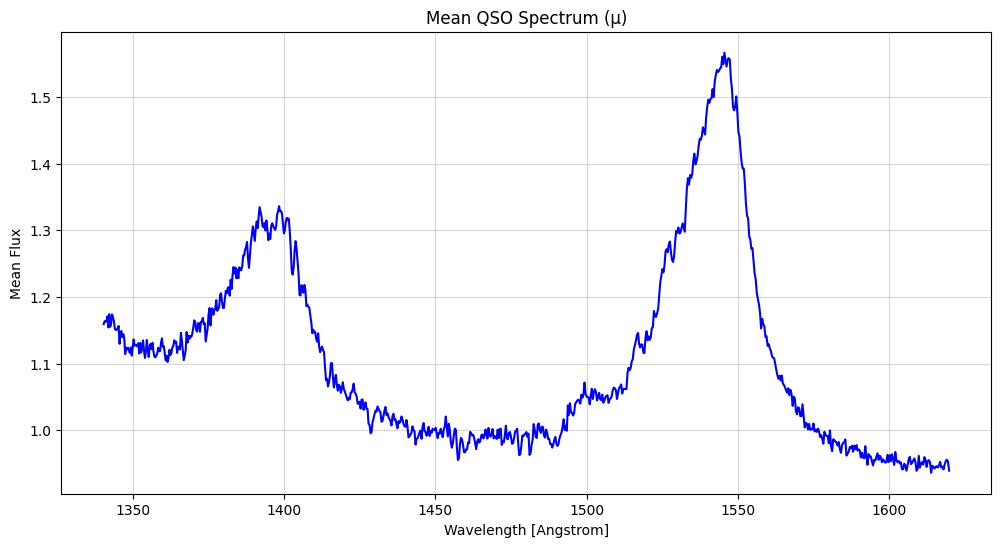

In [ ]:
mu = np.mean(X, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(wavelength, mu, color='blue')

plt.title('Mean QSO Spectrum (μ)')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Mean Flux')
plt.grid(True, alpha=0.5)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>
"Expectation Maximization (EM) is an iterative technique for solving parameters to maximize a likelihood function for models with unknown hidden (or latent) variables. Each iteration involves two steps: finding the expectation value of the hidden variables given the current model (E-step), and then modifying the model parameters to maximize the fit likelihood given the estimates of the hidden variables (M-step)." (https://arxiv.org/pdf/1208.4122.pdf)
<br><br>
Now, do Expectation Maximization PCA. In this case, we wish to solve for the eigenvectors, and the latent variables are the coefficients $c$. The likelihood is "the ability of the eigenvectors to describe the data."
<br><br>
First, find the eigenvector $\phi_1$ with the highest eigenvalue (the first principal eigenvector):
<br><br>
1. Initialize: Let $\phi$ is a random vector of length 824.
<br><br>
2. <b>E-step</b>: For each QSO $j$, $$c_j = X_{row\ j} \cdot \phi$$ <br> Here, "$\cdot$" represents a dot product, so $X_{row\ j}$ and $\phi$ are vectors of length 824, so $c_j$ is a number. $c = [c_1\ c_2\ ...\ c_{18}]$ is a vector of length 18 (because we have 18 QSOs in this problem). So for each QSO $j$, we solve the coefficient $c_j$ which best fits that QSO using $\phi$.
<br><br>
3. <b>M-step</b>: $$\phi = \frac{\sum_j c_j\ X_{row\ j}}{\sum_j c_j^2} $$
<br>
Using the coefficients $c_j$, we update $\phi$ to find the vector which best fits the data given $c_j$.
<br><br>
4. Normalize:
$$ \phi = \frac{\phi}{|\phi|} $$
<br><br>
5. Iterate until converged. Once converged, $c_1 = c$, and $\phi_1 = \phi$
<br><br>


After you get $\phi_1$, subtract the projection of $\phi$ from $X$ ($X - c_1 \otimes \phi_1$, where "$\otimes$" is the outer product (https://en.wikipedia.org/wiki/Outer_product). $c_1$ is a vector of length 18, and $\phi_1$ is a vector of length 824, so $c_1 \otimes \phi_1$ is a $18 \times 824$ matrix.) and repeat the EM algorithm.
<br><br>
(So to find $\phi_2$, you should use a data matrix $X - c \otimes \phi_1$. To find $\phi_2$, use $X - c_1 \otimes \phi_1 - c_2 \otimes \phi_2$), and so on.
<br><br>
<span style="color:blue"> <i> 2. Using EM PCA, find the first three principal eigenvectors $\phi_1, \phi_2, \phi_3$ and plot them as a function of wavelength.  </i></span> <br>

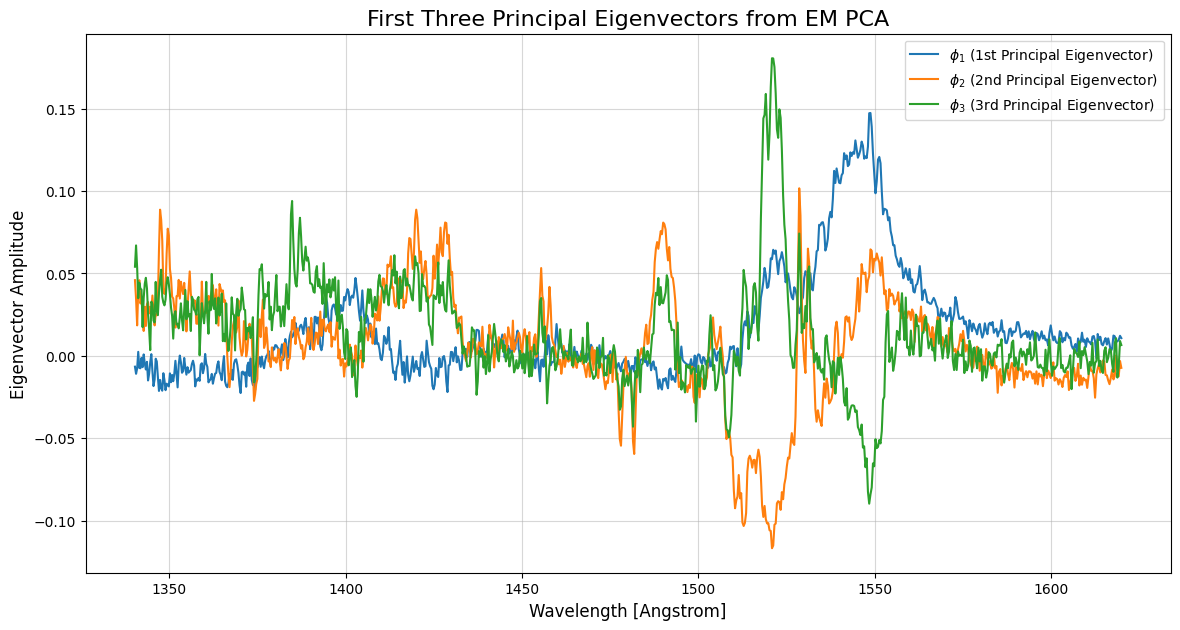

In [ ]:
mu = np.mean(X, axis=0)
X_c = X - mu

n_qso, n_lambda = X.shape
n_components = 3
eigenvectors = np.zeros((n_components, n_lambda))
coefficients = np.zeros((n_qso, n_components))
X_residual = X_c.copy()

np.random.seed(rng_seed)

for k in range(n_components):

    phi_k = np.random.rand(n_lambda)
    phi_k /= np.linalg.norm(phi_k)

    for i in range(50):
        c_k = np.dot(X_residual, phi_k)

        phi_k_new = np.dot(c_k, X_residual) / np.dot(c_k, c_k)

        phi_k_new /= np.linalg.norm(phi_k_new)

        if np.allclose(phi_k, phi_k_new):
            break
        phi_k = phi_k_new

    eigenvectors[k, :] = phi_k
    coefficients[:, k] = np.dot(X_residual, phi_k) 

    X_residual -= np.outer(coefficients[:, k], phi_k)

phi_1, phi_2, phi_3 = eigenvectors

plt.figure(figsize=(14, 7))
plt.title('First Three Principal Eigenvectors from EM PCA', fontsize=16)
plt.xlabel('Wavelength [Angstrom]', fontsize=12)
plt.ylabel('Eigenvector Amplitude', fontsize=12)

plt.plot(wavelength, phi_1, label=r'$\phi_1$ (1st Principal Eigenvector)')
plt.plot(wavelength, phi_2, label=r'$\phi_2$ (2nd Principal Eigenvector)')
plt.plot(wavelength, phi_3, label=r'$\phi_3$ (3rd Principal Eigenvector)')

plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Finally, reconstruct the data using the first principal eigenvectors:
<br><br>
$$ \hat{X} = \sum_{k = 1}^3 c_k \otimes \phi_k $$
<br>
<span style="color:blue"> <i> 3. For any one QSO spectra, plot the original and reconstructed spectra, using the above equation. </i></span> <br>

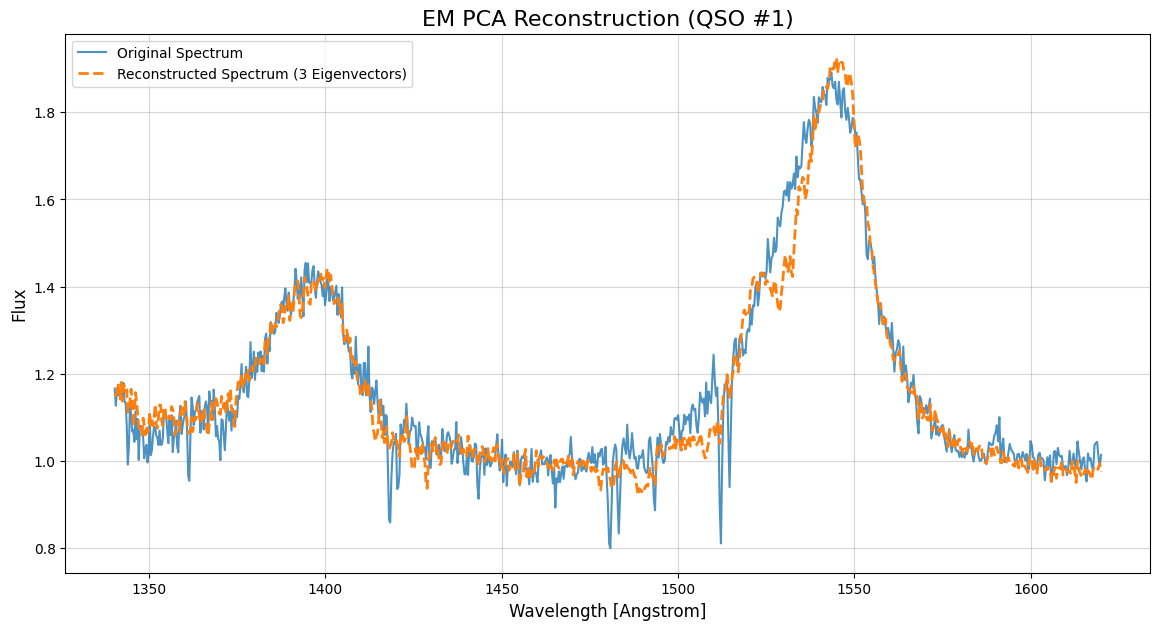

In [91]:
X_reconstructed_centered = np.dot(coefficients, eigenvectors)
X_reconstructed = X_reconstructed_centered + mu

qso_index_to_plot = 0

original_spectrum = X[qso_index_to_plot]
reconstructed_spectrum = X_reconstructed[qso_index_to_plot]

plt.figure(figsize=(14, 7))
plt.title(f'EM PCA Reconstruction (QSO #{qso_index_to_plot + 1})', fontsize=16)
plt.xlabel('Wavelength [Angstrom]', fontsize=12)
plt.ylabel('Flux', fontsize=12)

plt.plot(wavelength, original_spectrum, label='Original Spectrum', alpha=0.8)
plt.plot(wavelength, reconstructed_spectrum, label='Reconstructed Spectrum (3 Eigenvectors)', linestyle='--', lw=2)

plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Alternatively, you can also reconstruct the data using "PC scores." (Call the PC score matrix $Z$)
<br><br>
$$ Z = X_c \phi $$
<br><br>
Then, we can reconstruct the data by mapping it back to 824 dimensions with $\bf \phi^T$:
<br><br>
$$ \hat{X} = \mu + Z \phi^T $$
<br>
<span style="color:blue"> <i> 4. For any one QSO spectra, plot the original and reconstructed spectra, using PC scores. </i></span> <br>

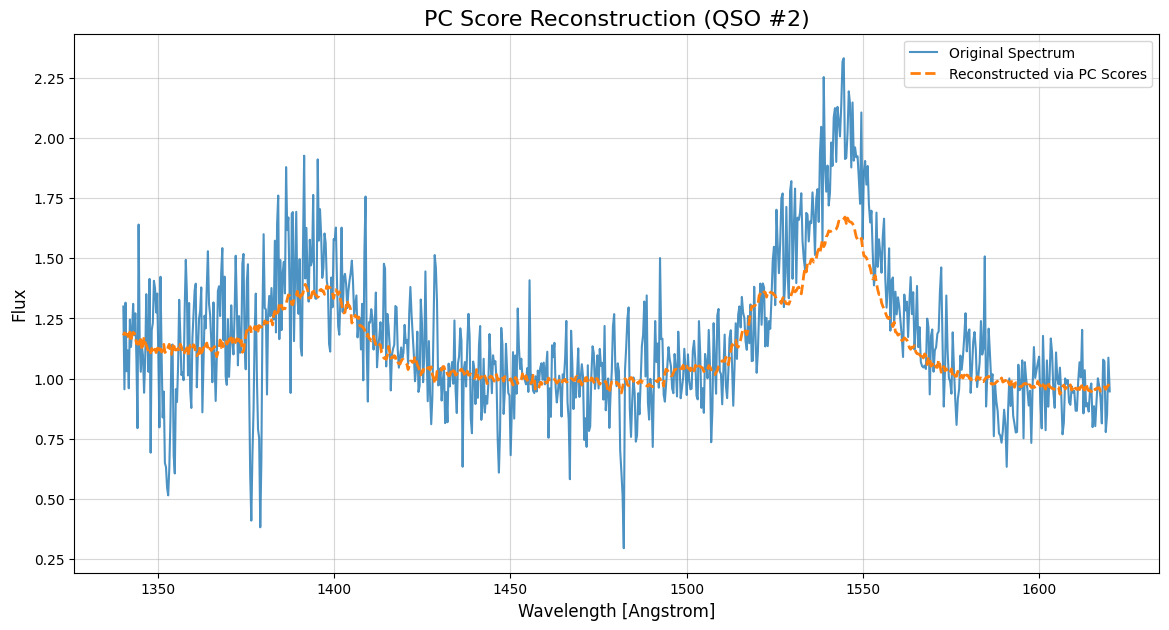

In [97]:
Z = np.dot(X_c, eigenvectors.T)

X_reconstructed_pc = mu + np.dot(Z, eigenvectors)

qso_index_to_plot = 1

original_spectrum = X[qso_index_to_plot]
reconstructed_spectrum_pc = X_reconstructed_pc[qso_index_to_plot]

plt.figure(figsize=(14, 7))
plt.title(f'PC Score Reconstruction (QSO #{qso_index_to_plot + 1})', fontsize=16)
plt.xlabel('Wavelength [Angstrom]', fontsize=12)
plt.ylabel('Flux', fontsize=12)

plt.plot(wavelength, original_spectrum, label='Original Spectrum', alpha=0.8)
plt.plot(wavelength, reconstructed_spectrum_pc, label='Reconstructed via PC Scores', linestyle='--', lw=2)

plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

<!-- END QUESTION -->

Now, include noisier QSO spectra.

In [98]:
# Load data
wavelength = np.loadtxt("./Problem3_wavelength_300.txt")
X = np.loadtxt("./Problem3_QSOspectra_300.txt")
ivar = np.loadtxt("./Problem3_ivar_flux_300.txt")

In [99]:
ivar[ivar==0] = 1.e-4

In [100]:
# Data dimension
print( np.shape(wavelength) )
print( np.shape(X) )
print( np.shape(ivar) )

(824,)
(2562, 824)
(2562, 824)


We now have 2562 quasars (including 18 high $S/N$ quasars we had before). The below cell plots the spectra of two quasars; you can see how noisy they are.

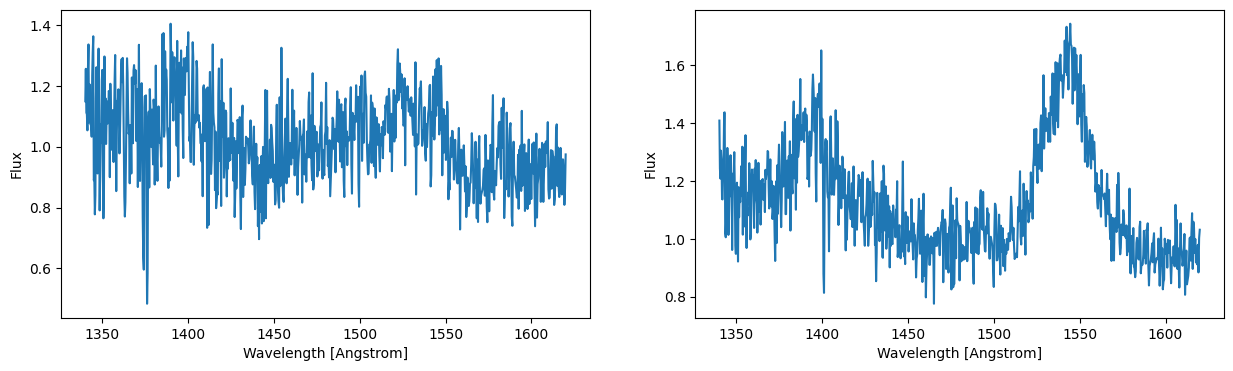

In [96]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
ax = axes[0]; i = 50
ax.plot(wavelength, X[i,:])
ax.set_xlabel('Wavelength [Angstrom]'); ax.set_ylabel('Flux')

ax = axes[1]; i = 500
plt.plot(wavelength, X[i,:])
ax.set_xlabel('Wavelength [Angstrom]'); ax.set_ylabel('Flux')
plt.show()

<!-- BEGIN QUESTION -->

<br><br>
Now, perform EM PCA on 2562 quasars.
<br><br>
<span style="color:blue"> <i> 5. Using EM PCA, find the first 10 principal eigenvectors $\phi_1, \phi_2, ..., \phi_{10}$ and reconstruct the data using them. ($ \hat{X} = \sum_{k = 1}^{10} c_k \otimes \phi_k $) For any two spectra, plot the original and reconstructed spectra. </i></span> <br>


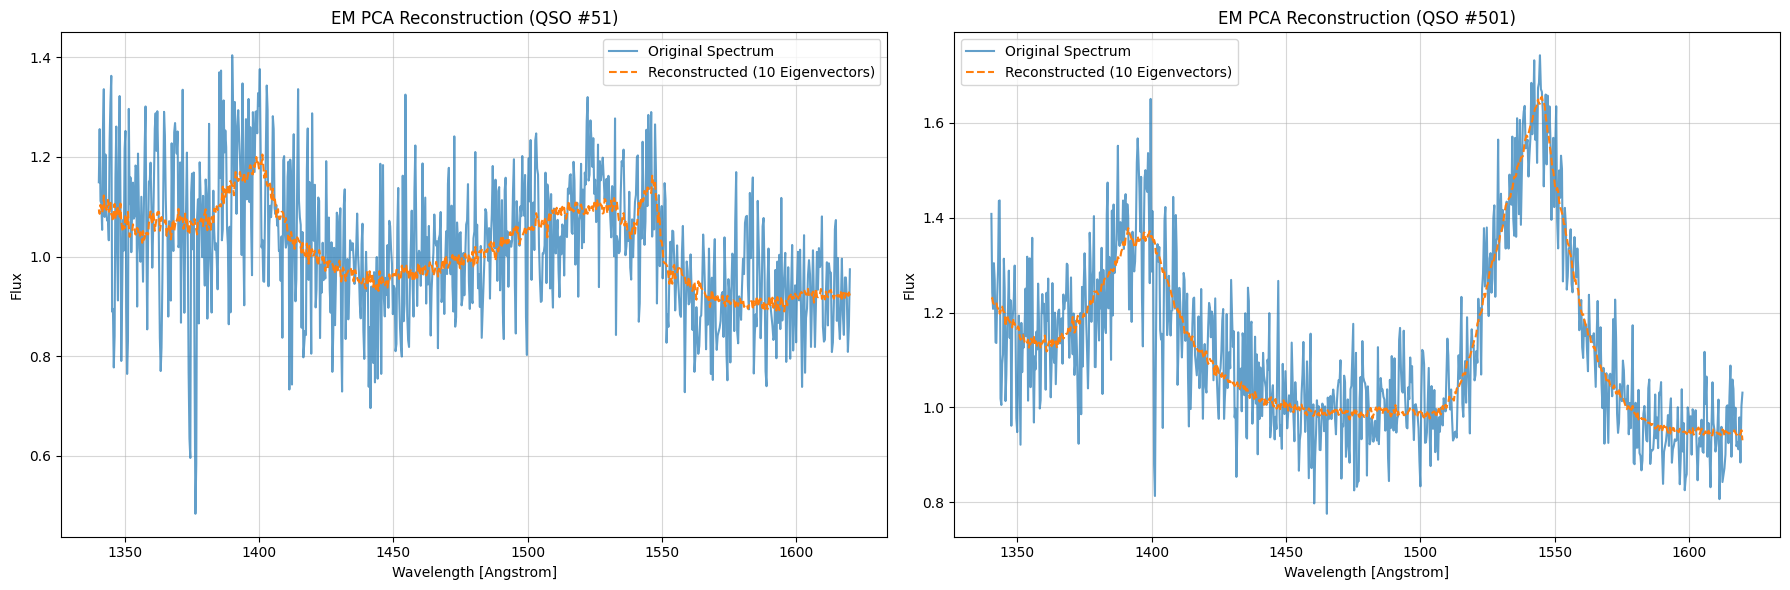

In [101]:
mu_300 = np.mean(X, axis=0)
X_c_300 = X - mu_300

n_qso, n_lambda = X.shape
n_components = 10
eigenvectors_300 = np.zeros((n_components, n_lambda))
coefficients_300 = np.zeros((n_qso, n_components))
X_residual_300 = X_c_300.copy()

np.random.seed(rng_seed)

for k in range(n_components):
    phi_k = np.random.rand(n_lambda)
    phi_k /= np.linalg.norm(phi_k)

    for i in range(50):
        c_k = np.dot(X_residual_300, phi_k)
        phi_k_new = np.dot(c_k, X_residual_300) / np.dot(c_k, c_k)
        phi_k_new /= np.linalg.norm(phi_k_new)

        if np.allclose(phi_k, phi_k_new):
            break
        phi_k = phi_k_new
        
    eigenvectors_300[k, :] = phi_k
    coefficients_300[:, k] = np.dot(X_residual_300, phi_k)
    X_residual_300 -= np.outer(coefficients_300[:, k], phi_k)

X_reconstructed_centered_300 = np.dot(coefficients_300, eigenvectors_300)
X_reconstructed_300 = X_reconstructed_centered_300 + mu_300

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

qso_index_1 = 50
ax1 = axes[0]
ax1.plot(wavelength, X[qso_index_1], label='Original Spectrum', alpha=0.7)
ax1.plot(wavelength, X_reconstructed_300[qso_index_1], label='Reconstructed (10 Eigenvectors)', linestyle='--')
ax1.set_title(f'EM PCA Reconstruction (QSO #{qso_index_1 + 1})')
ax1.set_xlabel('Wavelength [Angstrom]')
ax1.set_ylabel('Flux')
ax1.legend()
ax1.grid(True, alpha=0.5)

qso_index_2 = 500
ax2 = axes[1]
ax2.plot(wavelength, X[qso_index_2], label='Original Spectrum', alpha=0.7)
ax2.plot(wavelength, X_reconstructed_300[qso_index_2], label='Reconstructed (10 Eigenvectors)', linestyle='--')
ax2.set_title(f'EM PCA Reconstruction (QSO #{qso_index_2 + 1})')
ax2.set_xlabel('Wavelength [Angstrom]')
ax2.set_ylabel('Flux')
ax2.legend()
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<br>
So far we treated all data equally when solving for the eigenvectors. However, we find that some data have considerably larger measurement noise, and they can unduly influence the solution. Now, we perform EM PCA with per-observation weights (called weighted EMPCA) so that the high $S/N$ data receive greater weight. (See https://arxiv.org/pdf/1208.4122.pdf for more detailed explanation. The following description is paraphrased from this paper.)
<br><br>
Basically, we add weights $w$ to the measured data in M-step: $\phi = \sum_j w_j\ c_j\ X_{row\ j}$
<br><br>
In this case, the situation is more complicated since the measured flux in each wavelength bin for each quasar has a different weight. So we cannot do a simple dot product to derive $c$; instead, we must solve a set of linear equations for $c$. Similarly, M-step must solve a set of linear equations to update $\phi$ instead of just performing a simple sum. Hence, the weighted EMPCA starts with a set of random orthonormal vectors and iterates over.
<br><br>
1. Initialize: Let $\phi$ is a set of random orthonormal vectors.

In [102]:
# Create an aray of random orthonormal vectors
# Reference: https://github.com/sbailey/empca
def _random_orthonormal(nvec, nvar, seed=1):
    """
    Return array of random orthonormal vectors A[nvec, nvar]
    Doesn't protect against rare duplicate vectors leading to 0s
    """

    if seed is not None:
        np.random.seed(seed)

    A = np.random.normal(size=(nvec, nvar))
    for i in range(nvec):
        A[i] /= np.linalg.norm(A[i])

    for i in range(1, nvec):
        for j in range(0, i):
            A[i] -= np.dot(A[j], A[i]) * A[j]
            A[i] /= np.linalg.norm(A[i])

    return A

# Number of quasars
nQSO = len(X)
# Number of wavelength bins
nLambda = len(wavelength)
# Number of eigenvectors we want
nEigvec = 10

# A set of random orthonormal vectors
phi = _random_orthonormal(nLambda, nEigvec, seed=1)

2. <b>E-step</b>: $X_{row\ j} = \phi\ c_{col\ j}$. ($X_{row\ j}$ refers to $j$th row of $X$, and $c_{col\ j}$ is $j$th column of $c$. Note that $X$ is a matrix of dimension "nQSO" x "nLambda", $\phi$ is a matrix of dimension "nLambda" x "nEigvec", and $c$ is a matrix of dimension "nEigvec" x "nQSO".) Solve for $c$ assuming weights $w$.
<br><br>
We define weight $w$ as the inverse variance ("ivar"). (So $w$ is a matrix of dimension "nQSO" x "nLambda") This makes sense. "We weight the measured data by the estimated measurement variance so that noisy observations do not unduly affect the solution, while allowing PCA to describe the remaining signal variance."
<br><br>
Now, solve $X_{row\ j} = \phi\ c_{col\ j}$ for $c_{col\ j}$ with weights $w_{row\ j}$. More generally, let $A = \phi, x = c_{col\ j}, b = X_{row\ j}, w = w_{row\ j}$:
<br><br>
$$ b = Ax $$<br>
$$ wb = wAx$$<br>
$$ A^T wb = (A^T w A)x$$<br>
$$ (A^T w A)^{-1}A^T wb = x$$<br>
<br><br>
Hence, we get:<br><br>
$$ c_{col\ j} = (\phi^T w_{row\ j}\ \phi)^{-1}\ \phi^T w_{row\ j}\ X_{row\ j} $$
<br><br>
In the below cell, we define the function "_solve." <br> _solve(A, b, w) solves $Ax = b$ with weights $w$. This function solves $Ax = b$ with weights $w$ using $x = (A^T w A)^{-1}A^T wb$

In [103]:
# Solve Ax = b with weights w using the above set of equations
# Reference: https://github.com/sbailey/empca
def _solve(A, b, w):
    """
    Solve Ax = b with weights w; return x

    A : 2D array
    b : 1D array length A.shape[0]
    w : 1D array same length as b
    """

    #- Apply weights
    # nvar = len(w)
    # W = dia_matrix((w, 0), shape=(nvar, nvar))
    # bx = A.T.dot( W.dot(b) )
    # Ax = A.T.dot( W.dot(A) )

    b = A.T.dot( w*b )
    A = A.T.dot( (A.T * w).T )

    if isinstance(A, scipy.sparse.spmatrix):
        x = scipy.sparse.linalg.spsolve(A, b)
    else:
        x = np.linalg.lstsq(A, b)[0]

    return x

<!-- BEGIN QUESTION -->

Now, in the E-step, for each QSO $j$, we can solve $X_{row\ j} = \phi c_{col\ j}$ for $c_{col\ j}$ with weights $w_{row\ j}$ using the function "_solve".
<br><br>
Similarly in the M-step, for each wavelength bin $j$, we can solve $X_{col\ j} = c^T \phi_{row\ j}$ for $\phi_{row\ j}$ with weights $w_{col\ j}$ using the function "_solve".
<br><br>
<span style="color:blue"> <i> 6. The below cell uses the weighted EMPCA to find $\phi$. Fill in the blank and run the weighted EMPCA. </i></span> <br>

In [104]:
C = np.zeros( (nEigvec, nQSO) )

W = ivar

# Number of iteration for EMPCA
niteration = 20

for jj in range(niteration):
    print("iteration", jj+1, "/20")

    # E-step
    for i in range(nQSO):
        b = X[i] # SOLUTIOM
        A = phi
        w = ivar[i]
        C[:, i] = _solve(A, b, w)
        
    # M-step
    for j in range(nLambda):
        b = X[:, j] # SOLUTIOM
        A = C.T # SOLUTIOM
        w = W[:, j] # SOLUTIOM
        phi[j] = _solve(A, b, w)

iteration 1 /20
iteration 2 /20
iteration 3 /20
iteration 4 /20
iteration 5 /20
iteration 6 /20
iteration 7 /20
iteration 8 /20
iteration 9 /20
iteration 10 /20
iteration 11 /20
iteration 12 /20
iteration 13 /20
iteration 14 /20
iteration 15 /20
iteration 16 /20
iteration 17 /20
iteration 18 /20
iteration 19 /20
iteration 20 /20


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>
Reconstruct the data using $\phi$:<br><br>
$$ \hat{X} = (\phi c)^T $$
<br><br>
$\phi$ is a matrix of dimension "nLambda" x "nEigvec", and $c$ is a matrix of dimension "nEigvec" x "nQSO". So $\hat{X}$ is a matrix of dimension "nQSO" x "nLambda" as expected.
<br><br>
<span style="color:blue"> <i> 7. Reconstruct the data using the above equation. Remember that you chose two spectra in Part 5. For the same two spectra, plot the original and reconstructed spectra. Part 5 uses EMPCA without weights. Compared to Part 5, does your reconstructed spectra become less noisy?    </i></span> <br>

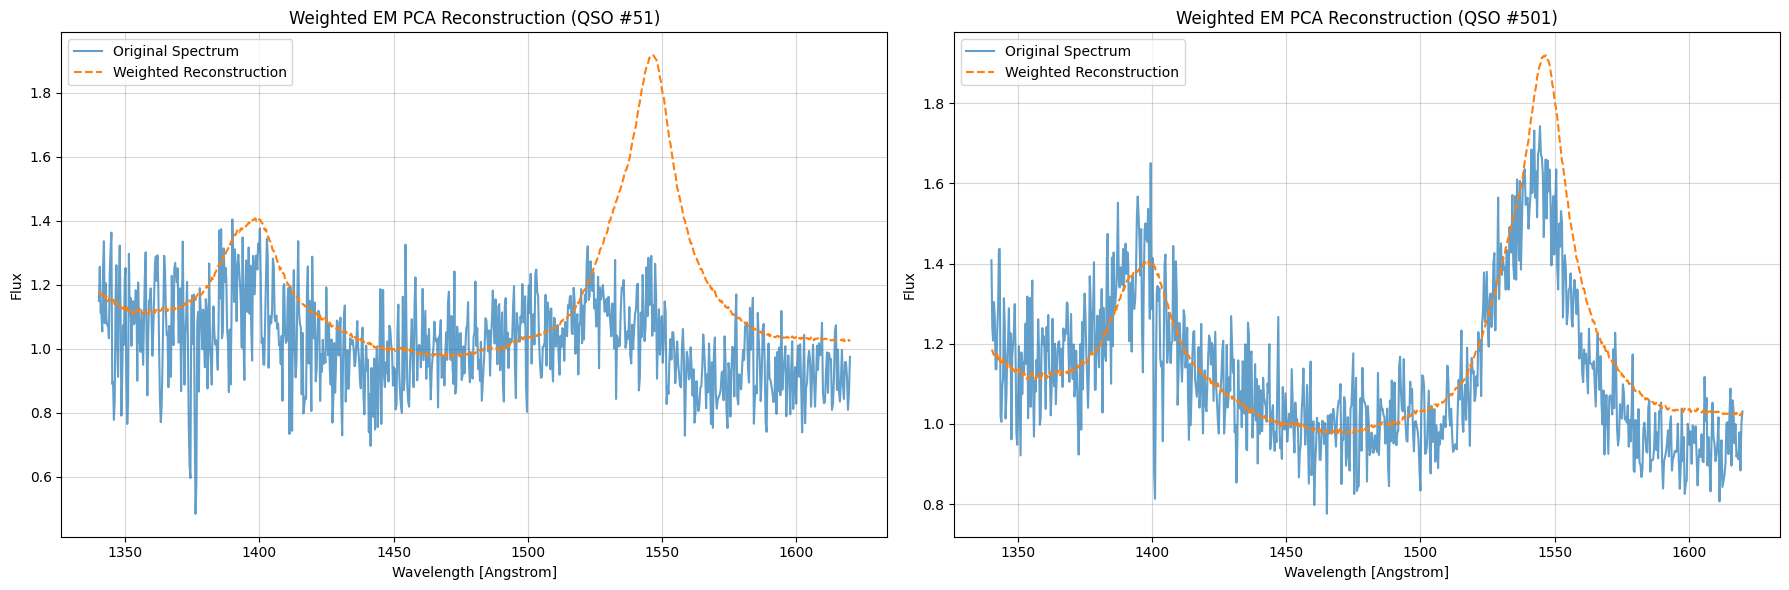


Compared to Part 5, the reconstructed spectra from the weighted EMPCA are noticeably less noisy. By giving less weight to noisy data points (those with low inverse variance), the algorithm builds eigenvectors that better represent the underlying signal, resulting in a smoother reconstruction.


In [105]:
mu_300 = np.mean(X, axis=0)
X_c_300 = X - mu_300
n_qso, n_lambda = X.shape
n_eigvec = 10

phi_weighted = _random_orthonormal(n_lambda, n_eigvec, seed=rng_seed)
C_weighted = np.zeros((n_qso, n_eigvec))
W = ivar

for iteration in range(20):
    for i in range(n_qso):
        C_weighted[i, :] = _solve(phi_weighted, X_c_300[i, :], W[i, :])

    for j in range(n_lambda):
        phi_weighted[j, :] = _solve(C_weighted, X_c_300[:, j], W[:, j])
        
for i in range(n_eigvec):
    for j in range(i):
        phi_weighted[:, i] -= np.dot(phi_weighted[:, j], phi_weighted[:, i]) * phi_weighted[:, j]
    phi_weighted[:, i] /= np.linalg.norm(phi_weighted[:, i])

X_reconstructed_weighted = np.dot(C_weighted, phi_weighted.T) + mu_300

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

qso_index_1 = 50
ax1 = axes[0]
ax1.plot(wavelength, X[qso_index_1], label='Original Spectrum', alpha=0.7)
ax1.plot(wavelength, X_reconstructed_weighted[qso_index_1], label='Weighted Reconstruction', linestyle='--')
ax1.set_title(f'Weighted EM PCA Reconstruction (QSO #{qso_index_1 + 1})')
ax1.set_xlabel('Wavelength [Angstrom]')
ax1.set_ylabel('Flux')
ax1.legend()
ax1.grid(True, alpha=0.5)

qso_index_2 = 500
ax2 = axes[1]
ax2.plot(wavelength, X[qso_index_2], label='Original Spectrum', alpha=0.7)
ax2.plot(wavelength, X_reconstructed_weighted[qso_index_2], label='Weighted Reconstruction', linestyle='--')
ax2.set_title(f'Weighted EM PCA Reconstruction (QSO #{qso_index_2 + 1})')
ax2.set_xlabel('Wavelength [Angstrom]')
ax2.set_ylabel('Flux')
ax2.legend()
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

print("\nCompared to Part 5, the reconstructed spectra from the weighted EMPCA are noticeably less noisy. "
      "By giving less weight to noisy data points (those with low inverse variance), the algorithm builds "
      "eigenvectors that better represent the underlying signal, resulting in a smoother reconstruction.")

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Due to an issue with the auto-generated PDF on the homework this week, please use Control (or Command) + P to print out the PDF for this week's homework. Submit the zip file to Gradescope still!

In [106]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/otter/check/notebook.py:494: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")


ExportFailedException: There was an error generating your LaTeX; showing full error message:
    Failed to run "['xelatex', 'notebook.tex', '-quiet']" command:
    This is XeTeX, Version 3.141592653-2.6-0.999997 (TeX Live 2025) (preloaded format=xelatex)
     restricted \write18 enabled.
    entering extended mode
    (./notebook.tex
    LaTeX2e <2024-11-01> patch level 2
    L3 programming layer <2025-01-18>
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/article.cls
    Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/graphicx.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/graphics.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/trig.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics-def/xetex.def)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/caption/caption.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/caption/caption3.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/float/float.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/xcolor/xcolor.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics-cfg/color.cfg)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/mathcolor.ltx))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/tools/enumerate.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
    For additional information on amsmath, use the `?' option.
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsfonts/amssymb.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/upquote/upquote.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/eurosym/eurosym.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/fontspec/fontspec.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/l3packages/xparse/xparse.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/l3kernel/expl3.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-xetex.def)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/fontspec/fontspec-xetex.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/fontenc.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/fontspec/fontspec.cfg)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/unicode-math/unicode-math.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/unicode-math/unicode-math-xetex.s
    ty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/l3packages/l3keys2e/l3keys2e.sty)
     (/usr/local/texlive/2025/texmf-dist/tex/latex/base/fix-cm.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/ts1enc.def))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/unicode-math/unicode-math-table.t
    ex))) (/usr/local/texlive/2025/texmf-dist/tex/latex/fancyvrb/fancyvrb.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/grffile/grffile.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/adjustbox/adjustbox.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/xkeyval/xkeyval.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/xkeyval/xkeyval.tex
    (/usr/local/texlive/2025/texmf-dist/tex/generic/xkeyval/xkvutils.tex)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/adjustbox/adjcalc.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/adjustbox/trimclip.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/collectbox/collectbox.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/adjustbox/tc-xetex.def))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/ifoddpage/ifoddpage.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/varwidth/varwidth.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hyperref/hyperref.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/kvsetkeys/kvsetkeys.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/kvdefinekeys/kvdefinekeys.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/pdfescape/pdfescape.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/infwarerr/infwarerr.sty)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hycolor/hycolor.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hyperref/nameref.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/refcount/refcount.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/gettitlestring/gettitlestring.s
    ty (/usr/local/texlive/2025/texmf-dist/tex/latex/kvoptions/kvoptions.sty)))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/stringenc/stringenc.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hyperref/pd1enc.def)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/intcalc/intcalc.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hyperref/puenc.def)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/url/url.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/bitset/bitset.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/bigintcalc/bigintcalc.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/atbegshi-ltx.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/hyperref/hxetex.def
    (/usr/local/texlive/2025/texmf-dist/tex/latex/rerunfilecheck/rerunfilecheck.sty
    (/usr/local/texlive/2025/texmf-dist/tex/latex/base/atveryend-ltx.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/uniquecounter/uniquecounter.sty
    ))) (/usr/local/texlive/2025/texmf-dist/tex/latex/titling/titling.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/tools/longtable.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/booktabs/booktabs.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/tools/array.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/tools/calc.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/enumitem/enumitem.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/ulem/ulem.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/soul/soul.sty
    (/usr/local/texlive/2025/texmf-dist/tex/generic/soul/soul-ori.sty)
    (/usr/local/texlive/2025/texmf-dist/tex/generic/etexcmds/etexcmds.sty))
    (/usr/local/texlive/2025/texmf-dist/tex/latex/jknapltx/mathrsfs.sty)
    No file notebook.aux.
    (/usr/local/texlive/2025/texmf-dist/tex/latex/caption/ltcaption.sty)
    *geometry* driver: auto-detecting
    *geometry* detected driver: xetex

    Package geometry Warning: The marginal notes overrun the paper.
         Add 3.73001pt and more to the right margin.

    *geometry* verbose mode - [ preamble ] result:
    * driver: xetex
    * paper: <default>
    * layout: <same size as paper>
    * layoutoffset:(h,v)=(0.0pt,0.0pt)
    * modes: 
    * h-part:(L,W,R)=(72.26999pt, 469.75502pt, 72.26999pt)
    * v-part:(T,H,B)=(72.26999pt, 650.43001pt, 72.26999pt)
    * \paperwidth=614.295pt
    * \paperheight=794.96999pt
    * \textwidth=469.75502pt
    * \textheight=650.43001pt
    * \oddsidemargin=0.0pt
    * \evensidemargin=0.0pt
    * \topmargin=-37.0pt
    * \headheight=12.0pt
    * \headsep=25.0pt
    * \topskip=10.0pt
    * \footskip=30.0pt
    * \marginparwidth=65.0pt
    * \marginparsep=11.0pt
    * \columnsep=10.0pt
    * \skip\footins=9.0pt plus 4.0pt minus 2.0pt
    * \hoffset=0.0pt
    * \voffset=0.0pt
    * \mag=1000
    * \@twocolumnfalse
    * \@twosidefalse
    * \@mparswitchfalse
    * \@reversemarginfalse
    * (1in=72.27pt=25.4mm, 1cm=28.453pt)


    Package hyperref Warning: Rerun to get /PageLabels entry.

    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsfonts/umsa.fd)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/amsfonts/umsb.fd)
    (/usr/local/texlive/2025/texmf-dist/tex/latex/jknapltx/ursfs.fd)
    [1]
    Underfull \hbox (badness 10000) in paragraph at lines 373--374


    [2]
    Underfull \hbox (badness 10000) in paragraph at lines 408--409


    [3]
    [4]
    [5]
    Underfull \hbox (badness 10000) in paragraph at lines 455--456


    [6]
    Missing character: There is no 𝜇 (U+1D707) in font [lmroman10-regular]:mapping=
    tex-text;!
    ! Missing $ inserted.
    <inserted text> 
                    $
    l.518 \begin{bmatrix}
                     
    ? 
    ! Emergency stop.
    <inserted text> 
                    $
    l.518 \begin{bmatrix}
                     
    Output written on notebook.pdf (6 pages).
    Transcript written on notebook.log.
